## Differential DNA methylation with Illumina 450K arrays (minfi + limma + DMRcate)

This notebook compares DNA methylation between two groups using Illumina HumanMethylation450 (“450K”) arrays. We use minfi to read IDATs, run QC, and perform Noob normalization; limma for CpG-level differential methylation; DMRcate for region-level DMRs. The example dataset is GEO GSE47915 (benign prostate tissue vs tumor; 8 total samples).


In [15]:
# Paths
data_dir <- "data"
ds_dir <- file.path(data_dir, "geo_gse47915_prostate_450k")
downloader <- file.path(data_dir, "downloaders", "download_geo_gse47915.R")

# Packages (assumes installed)
suppressPackageStartupMessages({
  library(minfi)
  library(limma)
  library(DMRcate)
  library(missMethyl)
  library(GEOquery)
  library(ggplot2)
  library(SummarizedExperiment)
  library(S4Vectors)
})

# Download dataset (creates ds_dir with idats/ + targets.csv)
source(downloader)
download_if_missing(data_dir, gse = "GSE47915")


Found 1 file(s)

GSE47915_series_matrix.txt.gz

Using locally cached version: C:\Users\dekel\AppData\Local\Temp\RtmpUVMkeA/GSE47915_series_matrix.txt.gz

Using locally cached version of GPL13534 found here:
C:\Users\dekel\AppData\Local\Temp\RtmpUVMkeA/GPL13534.soft.gz 



## 2) Load the IDATs into minfi

targets.csv provides a Basename per sample pointing to the paired *_Grn.idat / *_Red.idat files.
We load the IDATs into an RGChannelSet, then attach the targets table as phenotype metadata.


In [18]:
targets <- read.csv(file.path(ds_dir, "targets.csv"), stringsAsFactors = FALSE)
targets[, c("Sample_Name", "geo_accession", "Sample_Group", "Basename")]

rgSet <- read.metharray.exp(base = ds_dir, targets = targets, extended = TRUE)

# keep stable, human-readable sample names
colnames(rgSet) <- make.unique(targets$Sample_Name)

# store phenotype directly on the object
pheno <- targets
rownames(pheno) <- colnames(rgSet)
colData(rgSet) <- DataFrame(pheno)

rgSet
table(colData(rgSet)$Sample_Group, useNA = "ifany")


Sample_Name,geo_accession,Sample_Group,Basename
<chr>,<chr>,<chr>,<chr>
GSM1162363_6264509108_R01C02,GSM1162363,benign,idats/GSM1162363_6264509108_R01C02
GSM1162364_6264509130_R04C02,GSM1162364,tumor,idats/GSM1162364_6264509130_R04C02
GSM1162365_6264509130_R03C02,GSM1162365,tumor,idats/GSM1162365_6264509130_R03C02
GSM1162369_6264509130_R06C01,GSM1162369,tumor,idats/GSM1162369_6264509130_R06C01
GSM1162375_6264509130_R05C01,GSM1162375,tumor,idats/GSM1162375_6264509130_R05C01
GSM1162380_6285609104_R03C02,GSM1162380,benign,idats/GSM1162380_6285609104_R03C02
GSM1162381_6285650040_R06C02,GSM1162381,benign,idats/GSM1162381_6285650040_R06C02
GSM1162382_6285650050_R01C01,GSM1162382,benign,idats/GSM1162382_6285650050_R01C01


ERROR: Error in read.metharray(basenames = files, extended = extended, verbose = verbose, : The following specified files do not exist:data/geo_gse47915_prostate_450k/GSM1162363_6264509108_R01C02_Grn.idat, data/geo_gse47915_prostate_450k/GSM1162364_6264509130_R04C02_Grn.idat, data/geo_gse47915_prostate_450k/GSM1162365_6264509130_R03C02_Grn.idat, data/geo_gse47915_prostate_450k/GSM1162369_6264509130_R06C01_Grn.idat, data/geo_gse47915_prostate_450k/GSM1162375_6264509130_R05C01_Grn.idat, data/geo_gse47915_prostate_450k/GSM1162380_6285609104_R03C02_Grn.idat, data/geo_gse47915_prostate_450k/GSM1162381_6285650040_R06C02_Grn.idat, data/geo_gse47915_prostate_450k/GSM1162382_6285650050_R01C01_Grn.idat


## 3) Add group labels from GEO

The IDATs don’t always come with a “benign/tumor” column in targets.csv, so we pull the GEO sample titles and derive Sample_Group from whether the title contains “benign” (otherwise “tumor”). Then we join those labels onto our samples using the GSM accession in Sample_Name.

In [ ]:
gsm_pd <- Biobase::pData(getGEO("GSE47915", GSEMatrix = TRUE)[[1]])
meta <- data.frame(
  geo_accession = gsm_pd$geo_accession,
  title = gsm_pd$title,
  stringsAsFactors = FALSE
)
meta$Sample_Group <- ifelse(grepl("benign", meta$title, ignore.case = TRUE), "benign", "tumor")

cd <- as.data.frame(colData(rg))
gsm_id <- sub("_.*$", "", cd$Sample_Name)

cd$title <- meta$title[match(gsm_id, meta$geo_accession)]
cd$Sample_Group <- factor(
  meta$Sample_Group[match(gsm_id, meta$geo_accession)],
  levels = c("benign", "tumor")
)

colData(rg) <- S4Vectors::DataFrame(cd, row.names = rownames(cd))

table(colData(rg)$Sample_Group)
head(as.data.frame(colData(rg)[, c("Sample_Name", "Sample_Group", "title")]))


## 4) Quality control

The two most common early checks are:
- **Median intensity QC**: samples with unusually low methylated/unmethylated signal are often poor-quality.
- **Detection p-values**: probes with poor signal-to-noise in a sample can be filtered before modeling.


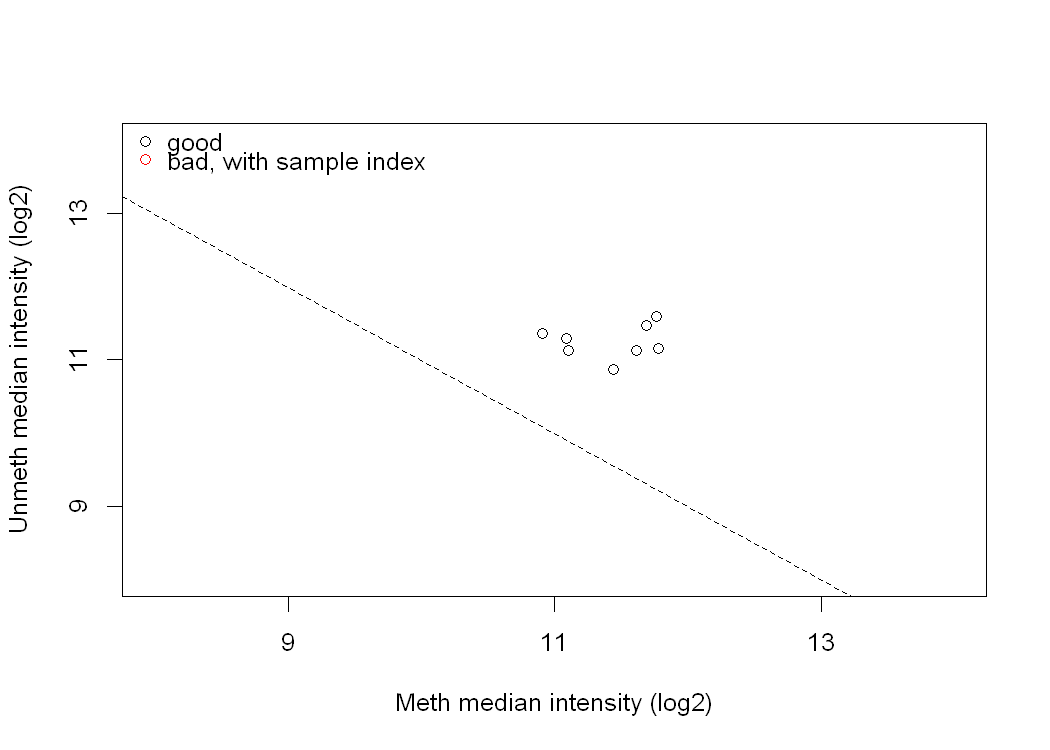

numeric(0)

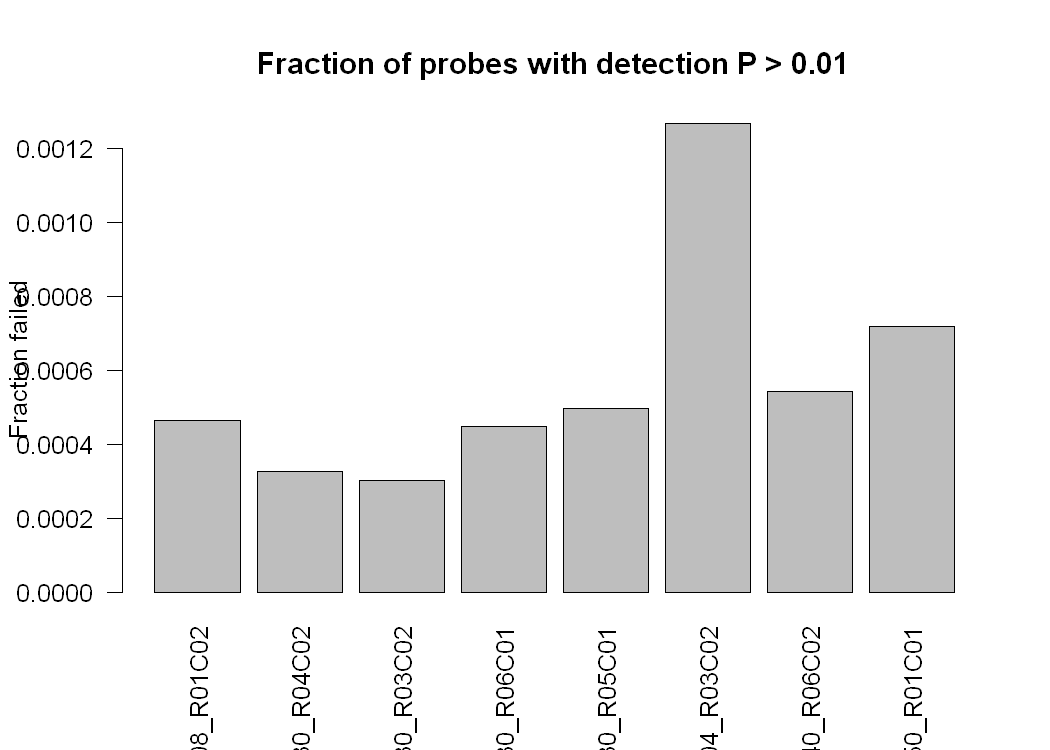

In [7]:
# Basic QC based on raw intensities
mSet_raw <- preprocessRaw(rgSet)

qc <- getQC(mSet_raw)
plotQC(qc)

# Detection p-values (probe-level)
detP <- detectionP(rgSet)

# Fraction of failed probes per sample (detP > 0.01)
frac_failed <- colMeans(detP > 0.01, na.rm = TRUE)
barplot(frac_failed, las = 2, main = "Fraction of probes with detection P > 0.01", ylab = "Fraction failed") +
abline(h = 0.01, lty = 2)

## 4) Normalization + quick exploration

We'll use **Noob** background correction (common default for 450K).  
Typical quick-look plots: Beta density (distribution shifts) and MDS/PCA (group separation, batch effects).


Loading required package: IlluminaHumanMethylation450kanno.ilmn12.hg19



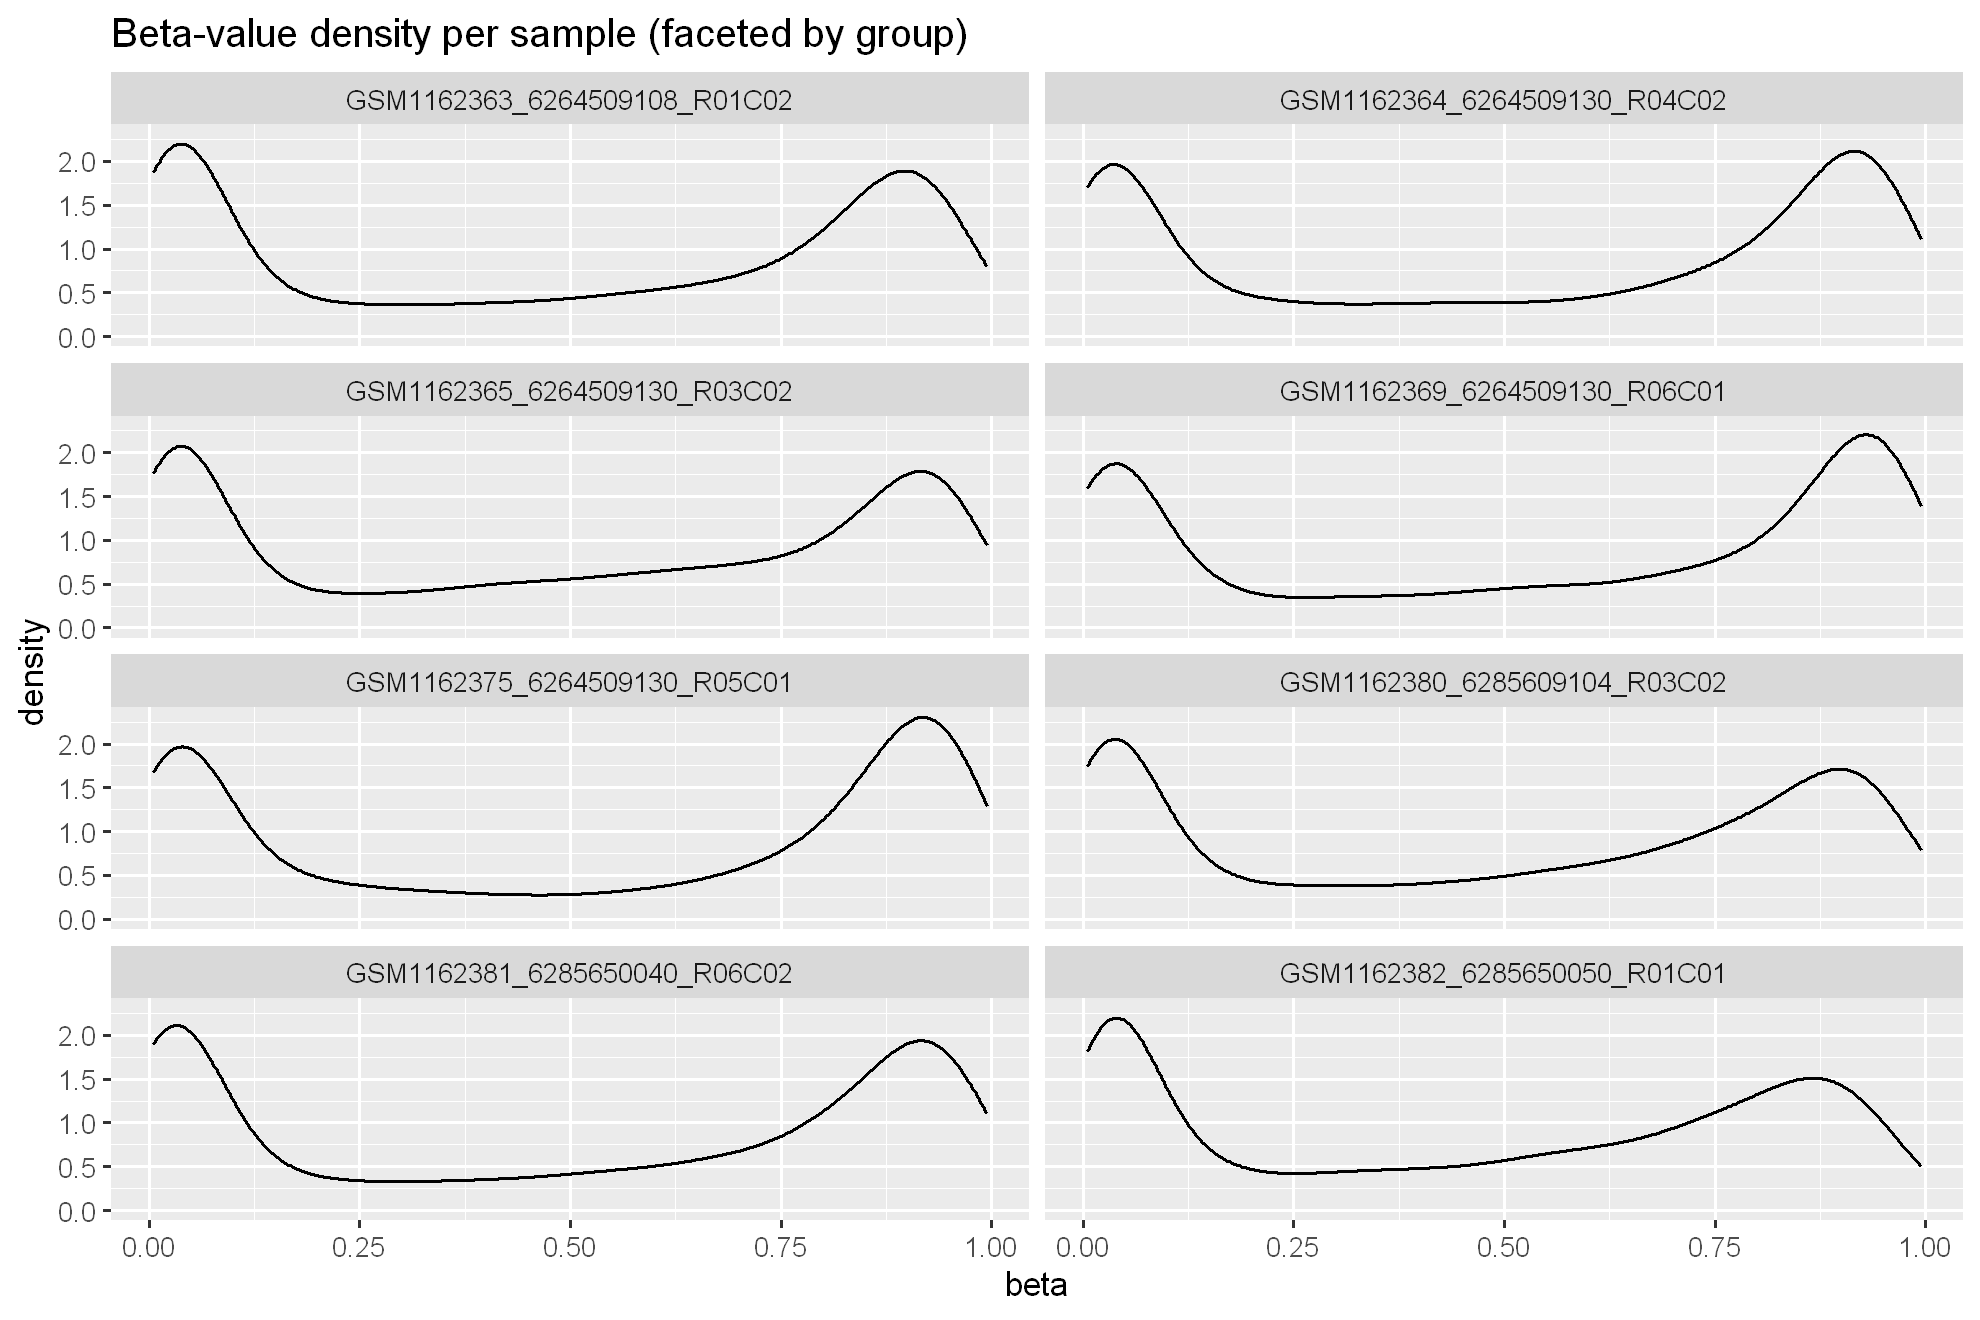

In [4]:
library(ggplot2)
library(SummarizedExperiment)

# Noob normalization returns a MethylSet
mSet_noob <- preprocessNoob(rgSet)

# Convert to genome-mapped ratio set for convenient Beta/M access
gSet <- mapToGenome(ratioConvert(mSet_noob, what = "both", keepCN = TRUE))

beta <- getBeta(gSet)
mvals <- getM(gSet)

# Pull grouping from colData; if not present, fall back to per-sample faceting
cd <- as.data.frame(colData(gSet))

group_vec <- colnames(beta)

# Ensure ordering matches the beta columns
names(group_vec) <- rownames(cd)
group_vec <- group_vec[match(colnames(beta), names(group_vec))]

# Beta density by group (sample probes for plotting efficiency)
set.seed(1)
idx <- sample(seq_len(nrow(beta)), 10000)

beta_long <- data.frame(
  beta   = as.vector(beta[idx, , drop = FALSE]),
  sample = rep(colnames(beta), each = length(idx)),
  group  = rep(group_vec, each = length(idx)),
  stringsAsFactors = FALSE
)

ggplot(beta_long, aes(x = beta, group = sample)) +
  geom_density(alpha = 0.15) +
  facet_wrap(~group, ncol = 2) +
  labs(title = "Beta-value density per sample (faceted by group)")



Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




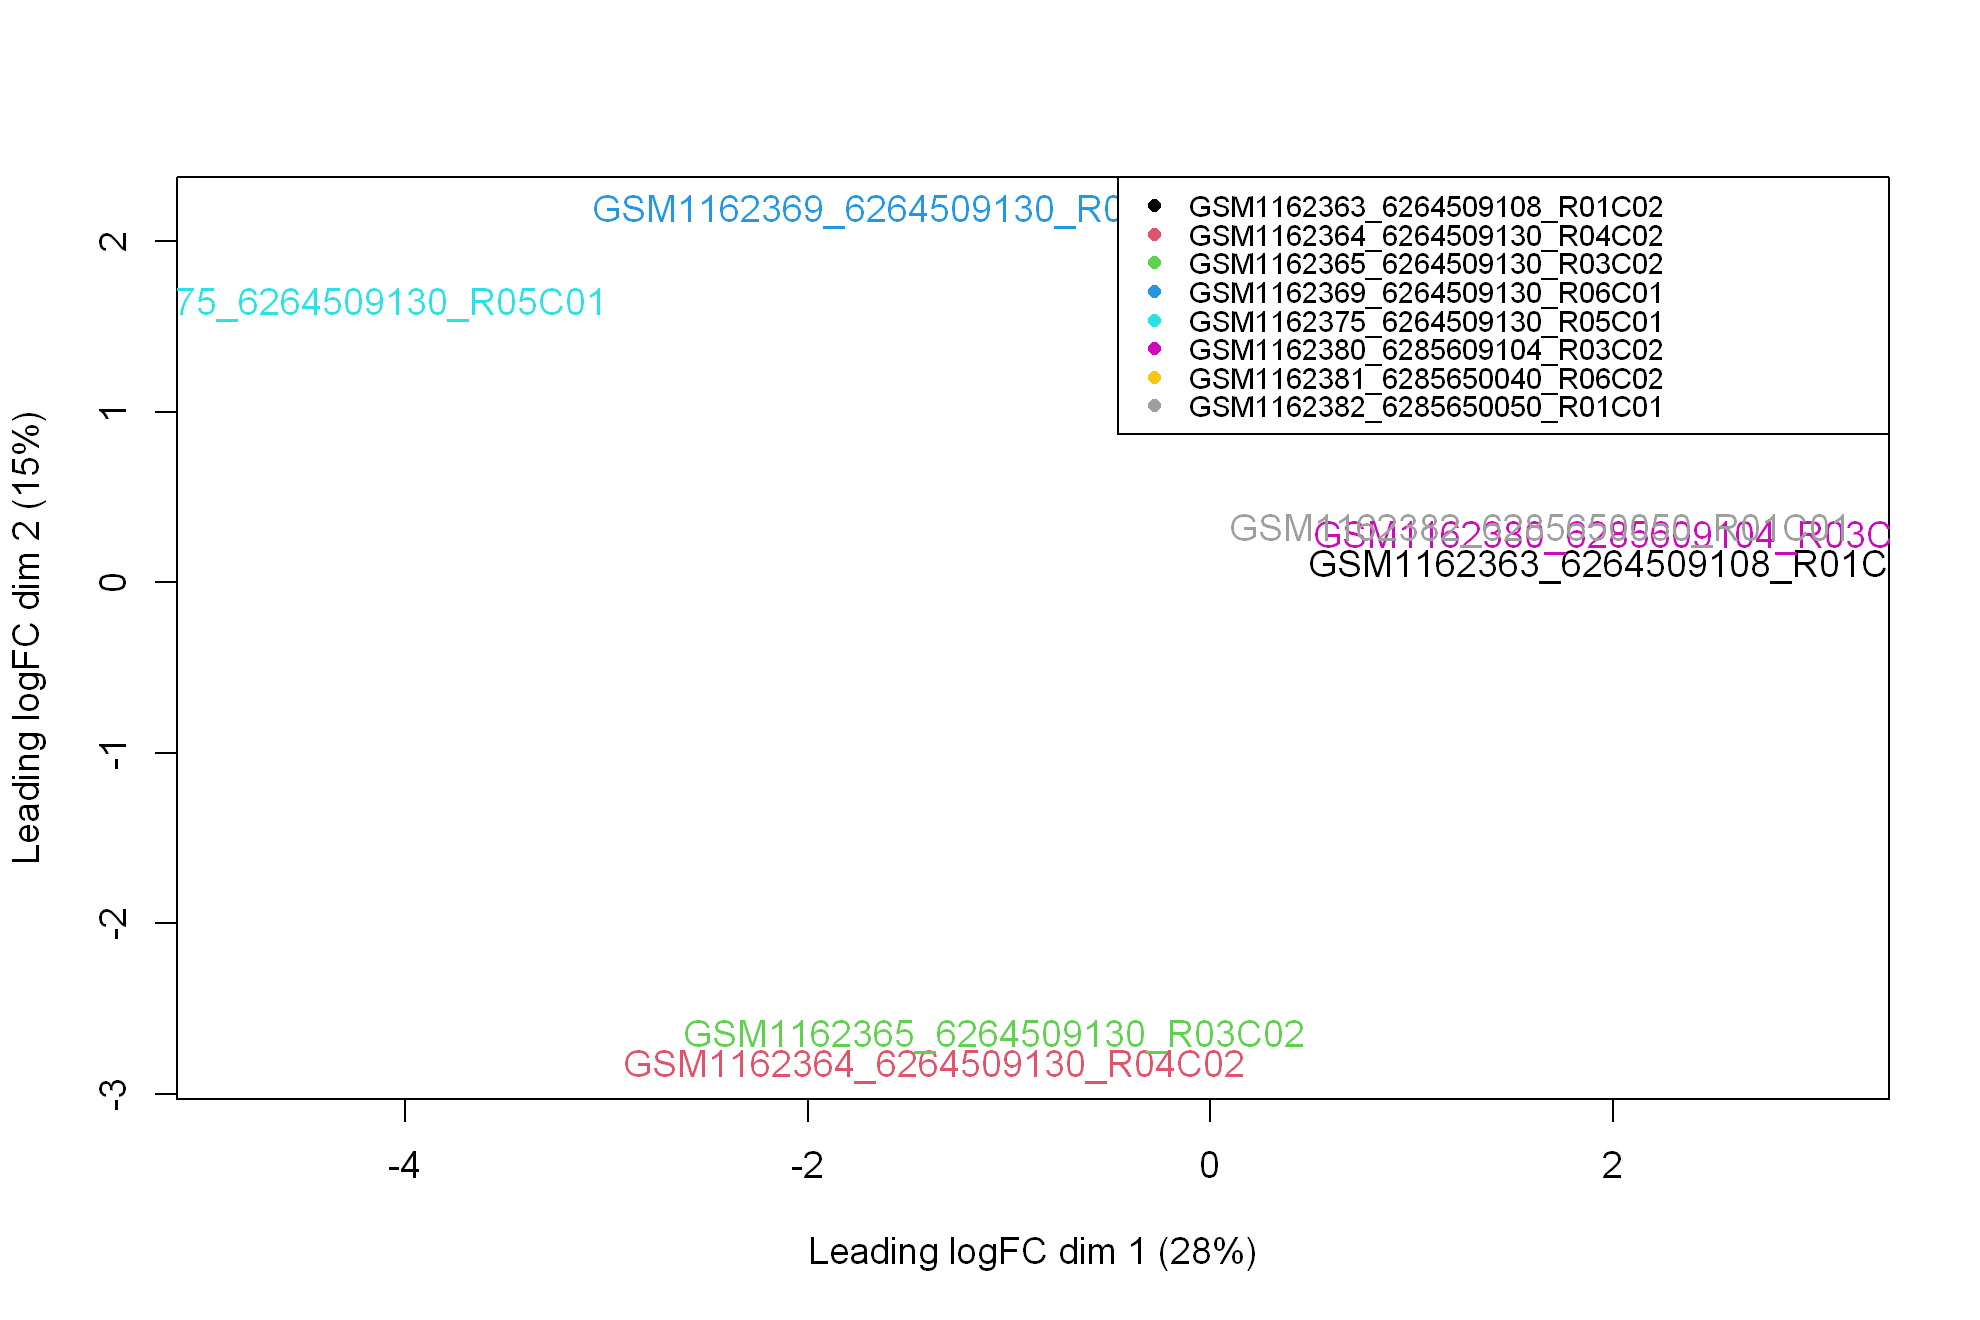

In [5]:
library(limma, quietly = TRUE)
library(SummarizedExperiment, quietly = TRUE)
# Pull group labels from colData (SummarizedExperiment-style)
cd <- as.data.frame(colData(gSet))

grp <- colnames(mvals)

# Ensure grp is in the same order as columns of mvals
names(grp) <- rownames(cd)
grp <- grp[match(colnames(mvals), names(grp))]

grp_f <- factor(grp)
cols <- as.integer(grp_f)

# MDS plot: samples closer together are more similar overall
limma::plotMDS(mvals, labels = grp_f, col = cols)

legend(
  "topright",
  legend = levels(grp_f),
  col = seq_along(levels(grp_f)),
  pch = 16,
  cex = 0.8
)


## 5) Probe filtering

As a filter, keep probes that pass detection P ≤ 0.01 in at least 90% of samples.

In real projects you’ll usually add filters for cross-reactive probes and probes affected by common SNPs (see “Additional considerations” at the end).


In [6]:
keep_probes <- rowMeans(detP <= 0.01, na.rm = TRUE) >= 0.90
sum(keep_probes)
gSet_f <- gSet[keep_probes, ]

beta_f <- getBeta(gSet_f)
mvals_f <- getM(gSet_f)


[1] 483894

## 6) Differential methylation at CpG sites (DMPs) with limma

We'll compare **naive vs rTreg** (resting regulatory T cells).  
We include **Donor** as a covariate to reduce donor-specific confounding.


In [7]:
library(GEOquery)
library(SummarizedExperiment)
library(S4Vectors)

# 1) Fetch GEO sample metadata (GSM titles include "Benign" / "Tumor")
gse <- getGEO("GSE47915", GSEMatrix = TRUE)
gsm_pd <- pData(gse[[1]])  # GEOquery returns an ExpressionSet here

meta <- data.frame(
  geo_accession = gsm_pd$geo_accession,
  title = gsm_pd$title,
  stringsAsFactors = FALSE
)

meta$Sample_Group <- ifelse(
  grepl("benign", meta$title, ignore.case = TRUE), "benign",
  ifelse(grepl("tumor", meta$title, ignore.case = TRUE), "tumor", NA)
)

# 2) Join onto your minfi object metadata via GSM ID (prefix of Sample_Name)
cd <- as.data.frame(colData(gSet_f))
cd$geo_accession <- sub("_.*$", "", cd$Sample_Name)

m <- meta[match(cd$geo_accession, meta$geo_accession), c("title", "Sample_Group")]
cd$title <- m$title
cd$Sample_Group <- m$Sample_Group

colData(gSet_f) <- DataFrame(cd, row.names = rownames(cd))

# Sanity check
table(colData(gSet_f)$Sample_Group, useNA = "ifany")
head(as.data.frame(colData(gSet_f))[, c("Sample_Name", "geo_accession", "Sample_Group", "title")])


Found 1 file(s)

GSE47915_series_matrix.txt.gz




benign  tumor 
     4      4 

,Sample_Name,geo_accession,Sample_Group,title
,<chr>,<chr>,<chr>,<chr>
GSM1162363_6264509108_R01C02,GSM1162363_6264509108_R01C02,GSM1162363,benign,6264509108_Benign_prostate_cancer_HM450K
GSM1162364_6264509130_R04C02,GSM1162364_6264509130_R04C02,GSM1162364,tumor,6264509130_1_Tumor_prostate_cancer_Gleason6_HM450K
GSM1162365_6264509130_R03C02,GSM1162365_6264509130_R03C02,GSM1162365,tumor,6264509130_2_Tumor_prostate_cancer_Gleason6_HM450K
GSM1162369_6264509130_R06C01,GSM1162369_6264509130_R06C01,GSM1162369,tumor,6264509130_3_Tumor_prostate_cancer_Gleason6_HM450K
GSM1162375_6264509130_R05C01,GSM1162375_6264509130_R05C01,GSM1162375,tumor,6264509130_4_Tumor_prostate_cancer_Gleason6_HM450K
GSM1162380_6285609104_R03C02,GSM1162380_6285609104_R03C02,GSM1162380,benign,6285609104 _Benign_prostate_cancer_HM450K


### Volcano-style view

You typically look for CpGs with both strong statistical support and meaningful methylation difference (e.g., |Δβ| ≥ 0.10).



 FALSE   TRUE 
444493  39401 

,logFC,P.Value,adj.P.Val,delta_beta
,<dbl>,<dbl>,<dbl>,<dbl>
cg20527270,6.173397,3.352924e-10,5.345878e-05,-0.0007449821
cg27299406,6.574279,3.680743e-10,5.345878e-05,0.0130907158
cg16794576,6.623313,4.792306e-10,5.345878e-05,0.0059765094
cg11849086,5.696038,6.112435e-10,5.345878e-05,0.0857028009
cg23511432,6.389217,6.127367e-10,5.345878e-05,-0.0025115793
cg19670286,5.976985,6.628574e-10,5.345878e-05,-0.0419408983


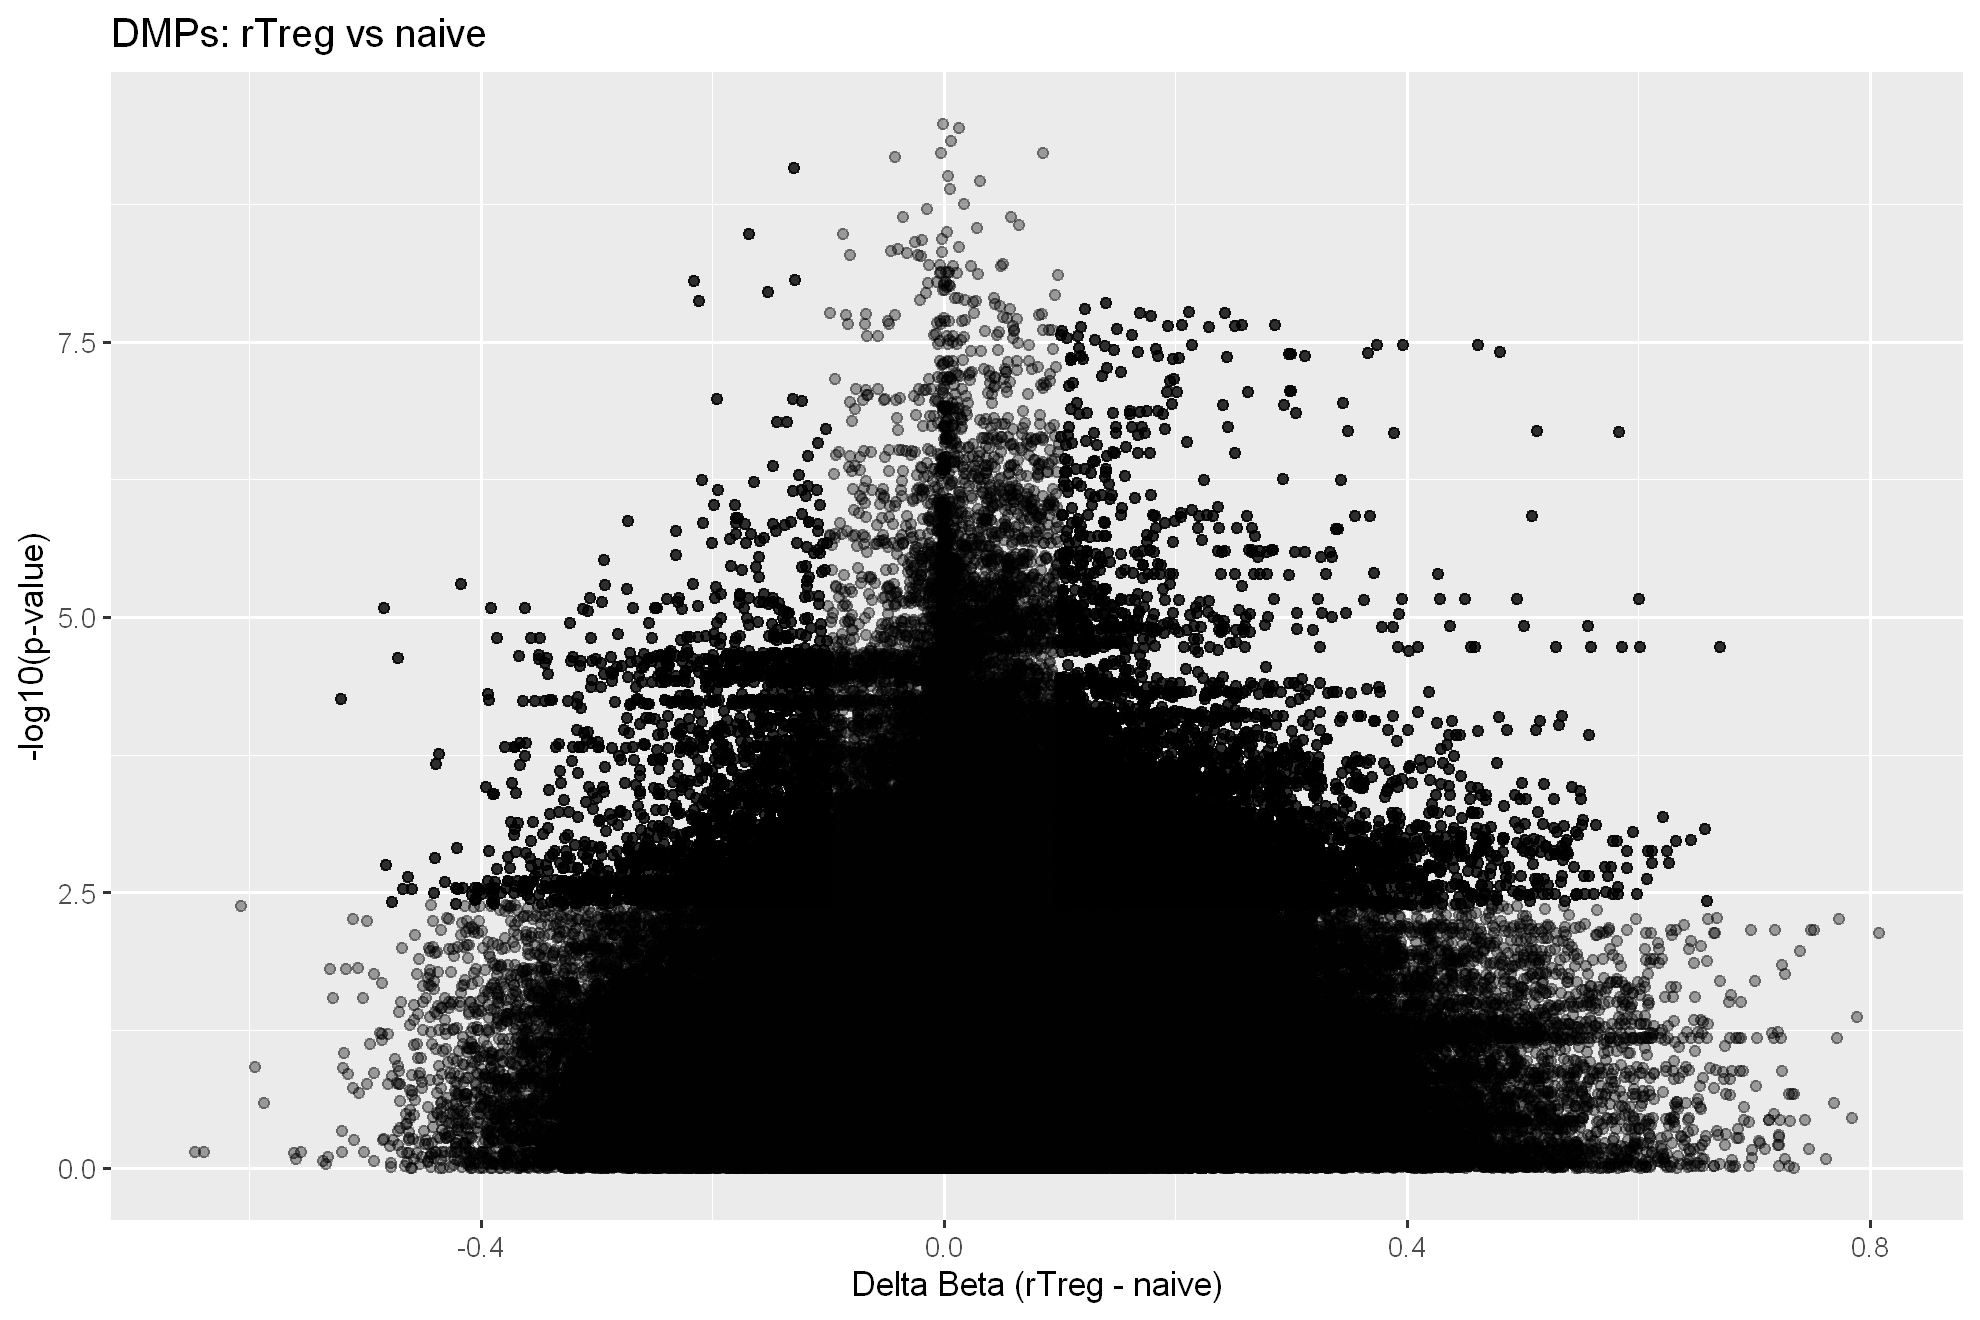

In [8]:
library(limma)
library(SummarizedExperiment)

pheno <- as.data.frame(colData(gSet_f))

# Keep only samples with a defined group
keep <- !is.na(pheno$Sample_Group)
gSet_sub <- gSet_f[, keep]
pheno_sub <- as.data.frame(colData(gSet_sub))

pheno_sub$Sample_Group <- factor(pheno_sub$Sample_Group, levels = c("benign", "tumor"))

m_sub <- getM(gSet_sub)
beta_sub <- getBeta(gSet_sub)

design <- model.matrix(~ 0 + Sample_Group, data = pheno_sub)
colnames(design) <- make.names(colnames(design))

cont <- makeContrasts(Sample_Grouptumor - Sample_Groupbenign, levels = design)

fit <- lmFit(m_sub, design)
fit2 <- contrasts.fit(fit, cont)
fit2 <- eBayes(fit2)

dmp <- topTable(fit2, number = Inf, sort.by = "P", adjust.method = "BH")

# Effect size: delta-beta (tumor - benign)
dmp$delta_beta <- rowMeans(beta_sub[, pheno_sub$Sample_Group == "tumor", drop = FALSE]) -
  rowMeans(beta_sub[, pheno_sub$Sample_Group == "benign", drop = FALSE])

table(dmp$adj.P.Val < 0.05)
head(dmp[, c("logFC", "P.Value", "adj.P.Val", "delta_beta")])


dmp$neglog10p <- -log10(dmp$P.Value)
dmp$hit <- (dmp$adj.P.Val < 0.05) & (abs(dmp$delta_beta) >= 0.10)

ggplot(dmp, aes(x = delta_beta, y = neglog10p)) +
  geom_point(alpha = 0.35) +
  geom_point(data = subset(dmp, hit), alpha = 0.7) +
  labs(title = "DMPs: rTreg vs naive", x = "Delta Beta (rTreg - naive)", y = "-log10(p-value)")


## 7) Regional differential methylation (DMRs) with DMRcate

DMRs are clusters of nearby CpGs that shift together, which often map more cleanly onto regulatory elements than individual CpGs.


### Visualize the top DMR

`DMR.plot()` shows CpGs in the region, a heatmap of sample beta values, and group means across the region.


[1] "cg13869341" "cg14008030" "cg12045430" "cg20826792" "cg00381604"
[6] "cg20253340"

Your contrast returned 39401 individually significant probes. We recommend the default setting of pcutoff in dmrcate().

Fitting chr1...

Fitting chr2...

Fitting chr3...

Fitting chr4...

Fitting chr5...

Fitting chr6...

Fitting chr7...

Fitting chr8...

Fitting chr9...

Fitting chr10...

Fitting chr11...

Fitting chr12...

Fitting chr13...

Fitting chr14...

Fitting chr15...

Fitting chr16...

Fitting chr17...

Fitting chr18...

Fitting chr19...

Fitting chr20...

Fitting chr21...

Fitting chr22...

Fitting chrX...

Fitting chrY...

Demarcating regions...

Done!

see ?DMRcatedata and browseVignettes('DMRcatedata') for documentation

loading from cache



GRanges object with 5 ranges and 8 metadata columns:
      seqnames            ranges strand |   no.cpgs min_smoothed_fdr
         <Rle>         <IRanges>  <Rle> | <integer>        <numeric>
  [1]     chr6 30708859-30713442      * |        89                0
  [2]     chr6 29972884-29976071      * |        57                0
  [3]    chr17 62773704-62778413      * |        25                0
  [4]     chr3 25468324-25469991      * |        17                0
  [5]     chr1   2460621-2463873      * |        15                0
          Stouffer       HMFDR       Fisher   maxdiff  meandiff
         <numeric>   <numeric>    <numeric> <numeric> <numeric>
  [1] 1.28224e-132 1.23864e-05 4.10863e-167  0.623305  0.246969
  [2] 1.01286e-186 8.98054e-06 8.39800e-184  0.771952  0.415598
  [3]  1.40964e-55 8.72417e-06  2.11788e-59  0.645002  0.275355
  [4]  1.16904e-74 1.71476e-05  5.16635e-68  0.726906  0.506321
  [5]  5.18218e-47 8.98054e-06  4.02930e-47  0.671163  0.375974
           overl

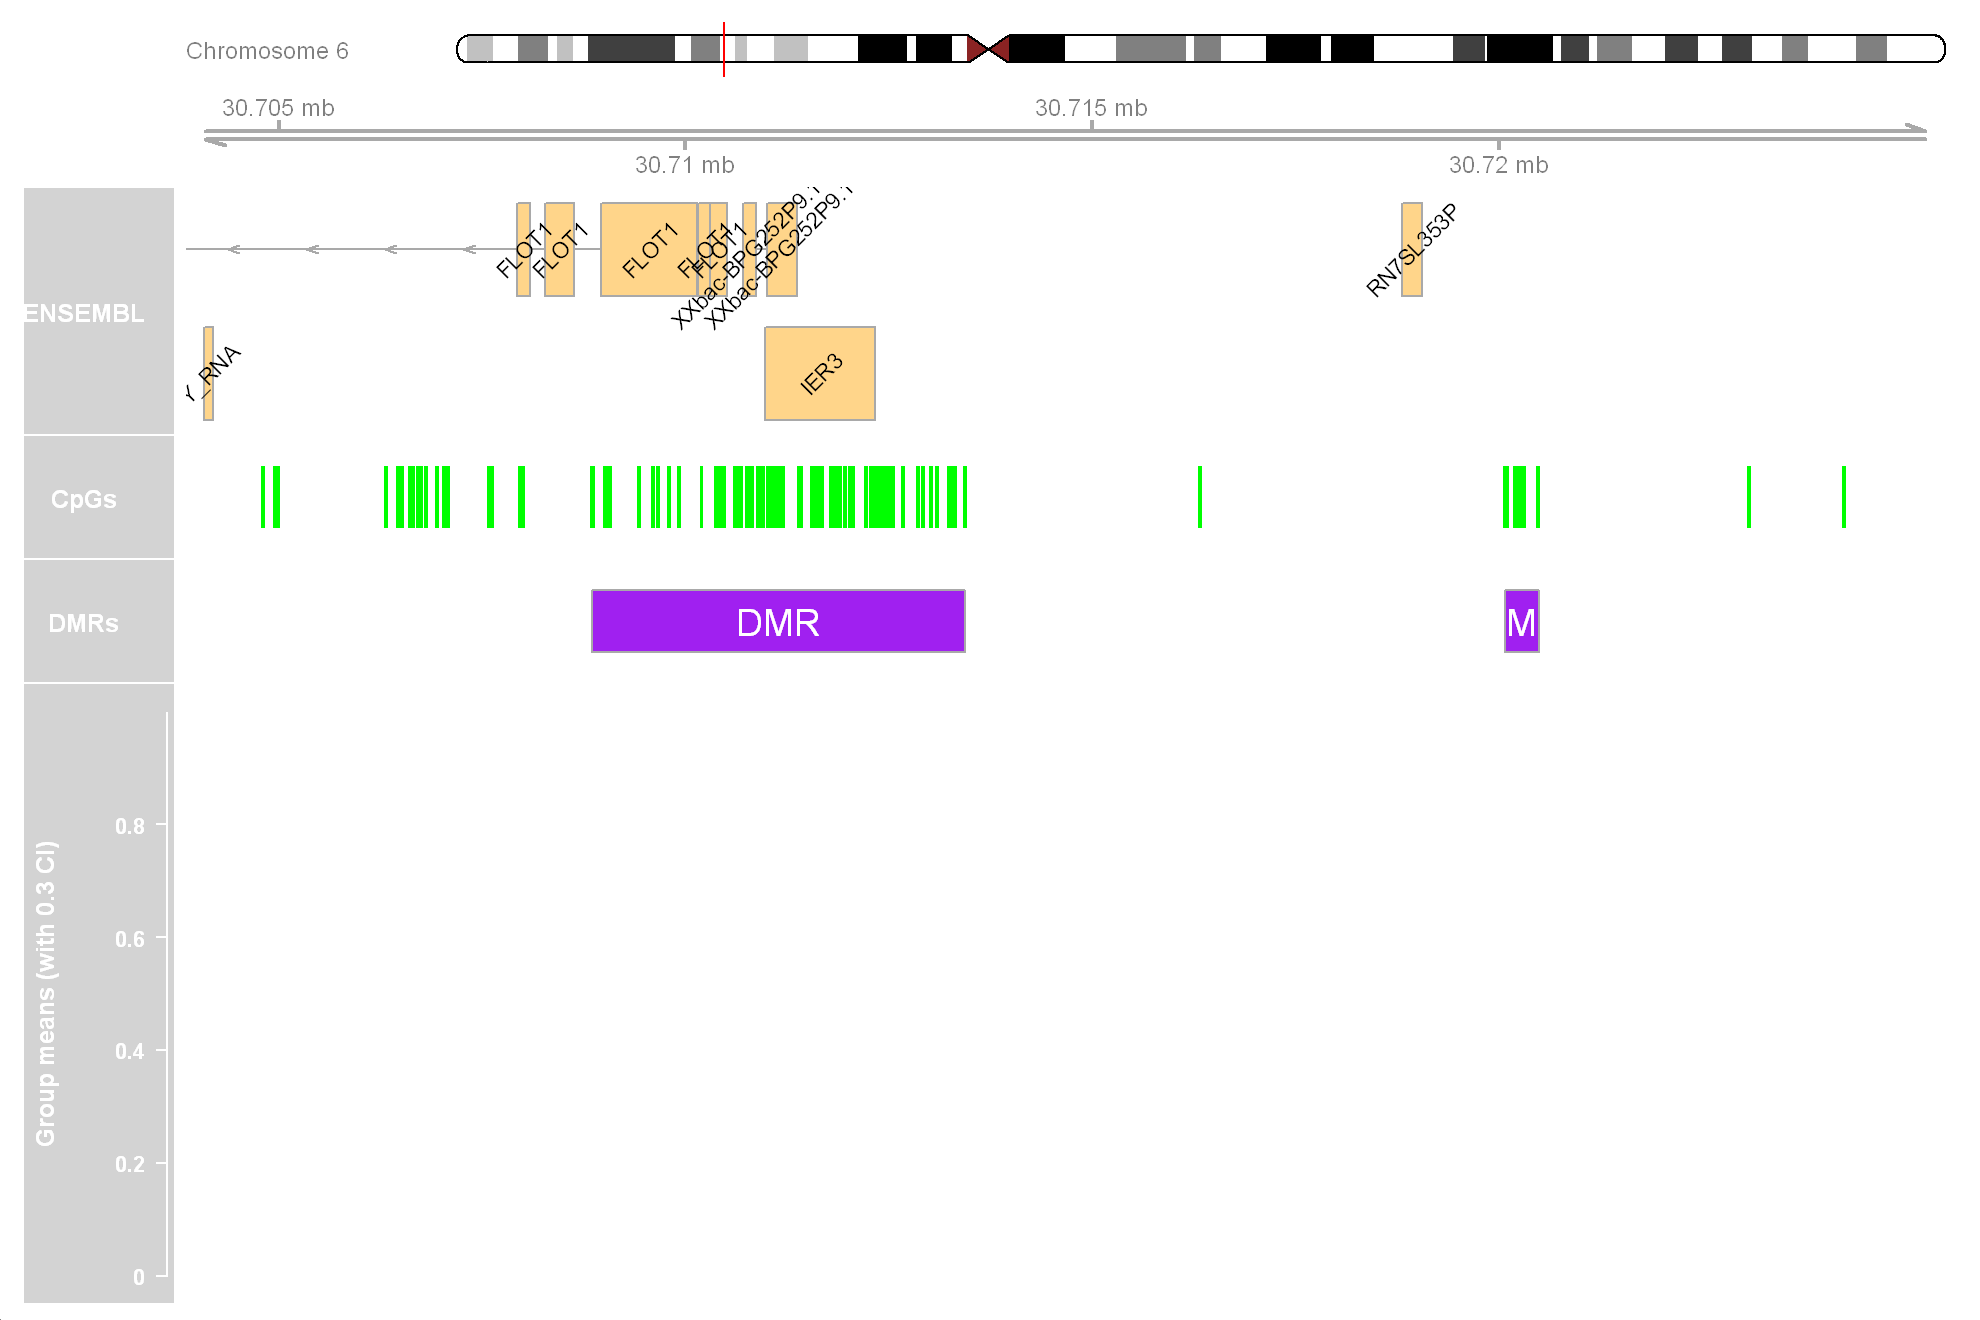

In [9]:
library(DMRcate)

# (Optional sanity check: 450K probes should look like "cg0000..."
head(rownames(beta_sub))

myAnnotation <- cpg.annotate(
  object = m_sub,
  datatype = "array",
  what = "M",
  analysis.type = "differential",
  design = design,
  contrasts = TRUE,
  cont.matrix = cont,
  coef = colnames(cont)[1],
  arraytype = "450K"
)

dmrc <- dmrcate(myAnnotation, lambda = 1000, C = 2)
dmrs <- extractRanges(dmrc, genome = "hg19")

dmrs[1:5]

# Plot first DMR (if present)
if (length(dmrs) > 0) {
  DMR.plot(
    ranges = dmrs,
    dmr = 1,
    CpGs = beta_sub,
    phen.col = pheno_sub$Sample_Group,
    arraytype = "450K",
    genome = "hg19"
  )
}


## 8) Gene set enrichment (GO / KEGG) with missMethyl

Gene set testing for methylation arrays is tricky because genes have different numbers of probes on the array.  
`gometh()` adjusts for this probe-number bias (and multi-gene mapping), which makes enrichment results more trustworthy.


In [ ]:
library(missMethyl)

# Use the CpGs you actually tested (background)
all_cpg <- rownames(m_sub)

# Significant CpGs (your choice of threshold)
sig_cpg <- rownames(dmp)[dmp$adj.P.Val < 0.05]

go <- gometh(
  sig.cpg = sig_cpg,
  all.cpg = all_cpg,
  collection = "GO",
  plot.bias = TRUE,
  array.type = "450K"
)

missMethyl::topGSA(go, number = 10)

kegg <- gometh(
  sig.cpg = sig_cpg,
  all.cpg = all_cpg,
  collection = "KEGG",
  array.type = "450K"
)

missMethyl::topGSA(kegg, number = 10)


[1] "white"

[1] 220

[1] "image/png"

## Additional considerations

- **Probe filtering**: in production you’ll usually remove cross-reactive probes, probes with common SNPs at the CpG or single-base extension, and (depending on your design) sex chromosome probes.
- **Normalization choice**: Noob is a good default; functional normalization (`preprocessFunnorm`) can be better when strong technical variation is present, especially in blood datasets with diverse cell mixes.
- **Batch effects**: if you have slide/plate/run information, include it in the design matrix (or use `duplicateCorrelation` / mixed models).
- **Cell composition**: for whole blood or tissues, estimate and adjust cell proportions (e.g., `estimateCellCounts`)—but for sorted cells like this dataset it’s less relevant.


## Typical follow-ups

- Plot methylation across *specific loci* of interest (e.g., FOXP3 enhancers) and link to expression if available.
- Run **epigenetic age** / clock estimates if the design includes age-related questions.
- Integrate with ATAC-seq/ChIP-seq to interpret DMRs in regulatory context.
